## Load model

In [1]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

In [2]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("")

## Load image

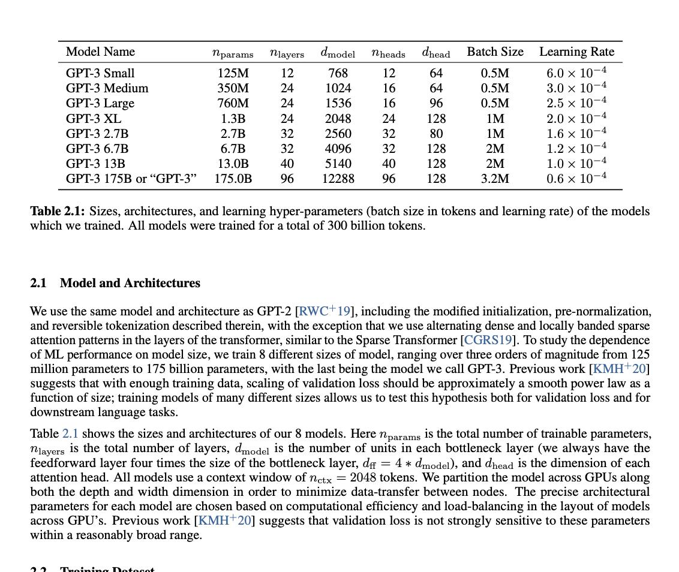

In [4]:
from PIL import Image
from huggingface_hub import hf_hub_download

# let's load an example image
file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="image.png")
file_path = 'data/input/image_1.jpg'
# file_path = 'data/input/image_2.png'
# file_path = 'data/input/image_3.png'
# file_path = 'data/input/table_example.png'
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

## Prepare image for the model

In [5]:
from transform import MaxResize, detection_transform

In [6]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 674, 800])


## Forward pass

In [9]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [10]:
outputs.logits.shape

torch.Size([1, 15, 3])

## Postprocessing

In [11]:
from postprocessing import box_cxcywh_to_xyxy, outputs_to_objects

# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"

In [12]:
objects = outputs_to_objects(outputs, image.size, id2label, iou_threshold=1)

In [13]:
print(objects)

[{'label': 'table', 'score': 0.9999572038650513, 'bbox': [110.22557067871094, 73.21591186523438, 1024.5753173828125, 308.76971435546875]}]


## Visualize

In [14]:
from visualize import fig2img, visualize_detected_tables

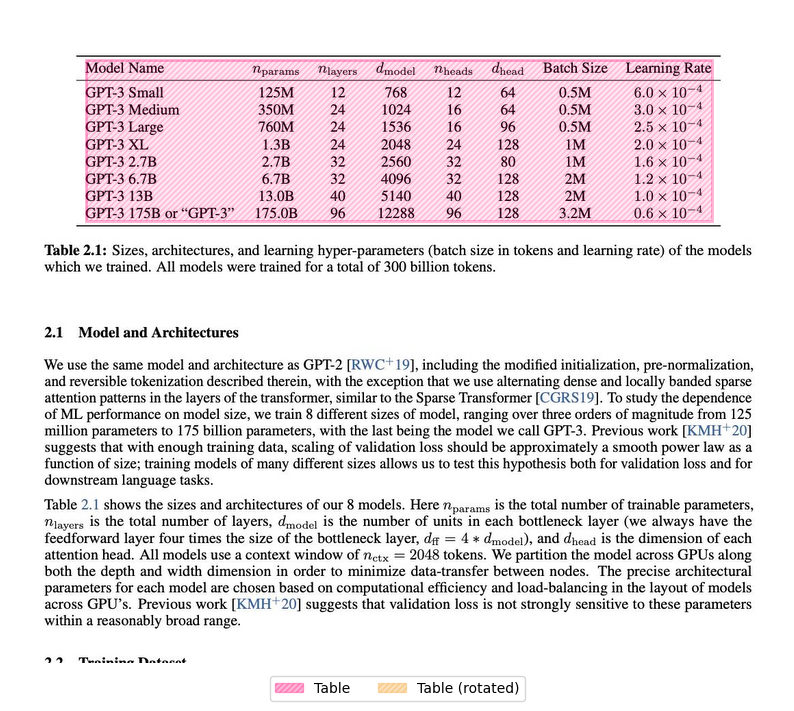

In [15]:
fig = visualize_detected_tables(image, objects)

In [16]:
visualized_image = fig2img(fig)

## Crop table

In [17]:
from utils import objects_to_crops

In [18]:
objects

[{'label': 'table',
  'score': 0.9999572038650513,
  'bbox': [110.22557067871094,
   73.21591186523438,
   1024.5753173828125,
   308.76971435546875]}]

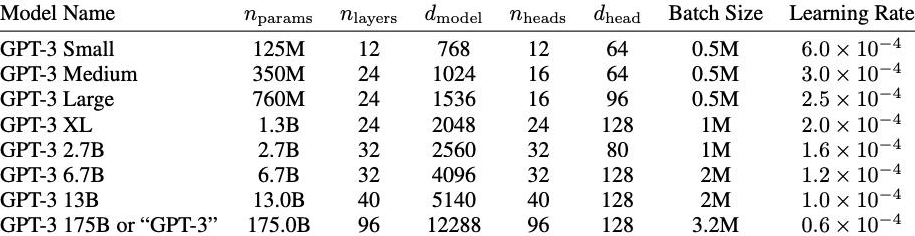

In [19]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [25]:
import os
os.makedirs('data/output', exist_ok =True)
cropped_table.save("data/output/table.jpg")

## Load structure recognition model

In [26]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

In [27]:
from transform import structure_transform

In [28]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 258, 1000])


In [29]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [30]:
structure_model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [31]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label, iou_threshold=0.95)
print(cells)

[{'label': 'table', 'score': 0.9999535083770752, 'bbox': [0.10498613119125366, 0.2774866819381714, 914.5703735351562, 235.67910766601562]}, {'label': 'table column', 'score': 0.9999191761016846, 'bbox': [775.5928344726562, 0.4314396381378174, 914.3751220703125, 235.72247314453125]}, {'label': 'table column', 'score': 0.999914288520813, 'bbox': [410.4644775390625, 0.5066683292388916, 497.15252685546875, 235.74850463867188]}, {'label': 'table column', 'score': 0.9999139308929443, 'bbox': [654.40966796875, 0.42502522468566895, 775.5294799804688, 235.7027587890625]}, {'label': 'table column', 'score': 0.9999022483825684, 'bbox': [-0.34410226345062256, 0.4688922166824341, 228.92526245117188, 235.71214294433594]}, {'label': 'table column', 'score': 0.9998651742935181, 'bbox': [230.33221435546875, 0.45457231998443604, 326.839599609375, 235.72915649414062]}, {'label': 'table column', 'score': 0.9998477697372437, 'bbox': [326.8551940917969, 0.5007673501968384, 409.16595458984375, 235.7050170898

## Visualize cells

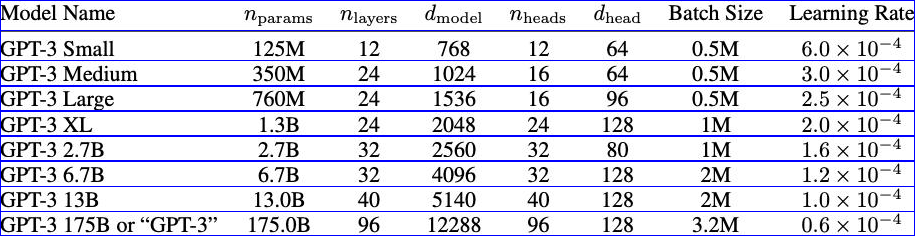

In [32]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    # print(cell["label"])
    # if cell["label"] == 'table column header':
    #     draw.rectangle(cell["bbox"], outline="red")
    # if cell["label"] == 'table column':
    #     draw.rectangle(cell["bbox"], outline="green")
    if cell["label"] == 'table row':
        draw.rectangle(cell["bbox"], outline="blue")
    # if cell["label"] == 'table':
    #     draw.rectangle(cell["bbox"], outline="black")

cropped_table_visualized

In [33]:
from visualize import plot_results

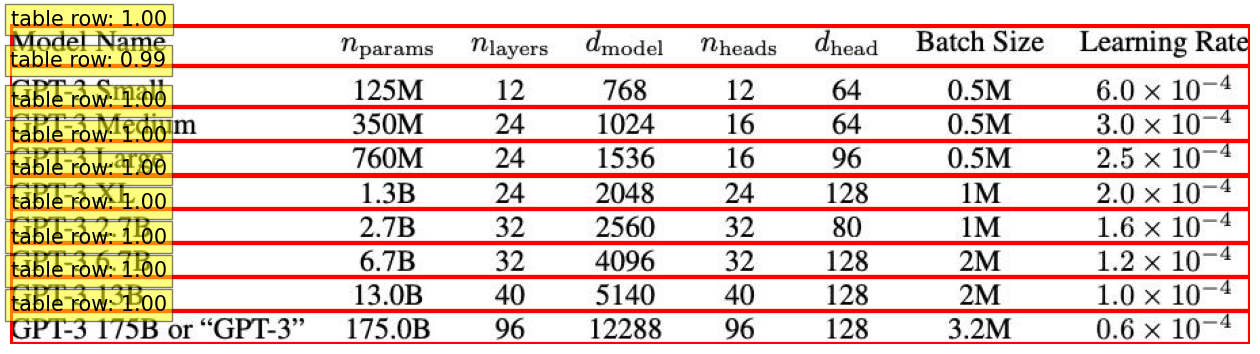

In [34]:
plot_results(cells, class_to_visualize="table row", structure_model=structure_model, cropped_table=cropped_table)

## Apply OCR row by row

In [35]:
cells

[{'label': 'table',
  'score': 0.9999535083770752,
  'bbox': [0.10498613119125366,
   0.2774866819381714,
   914.5703735351562,
   235.67910766601562]},
 {'label': 'table column',
  'score': 0.9999191761016846,
  'bbox': [775.5928344726562,
   0.4314396381378174,
   914.3751220703125,
   235.72247314453125]},
 {'label': 'table column',
  'score': 0.999914288520813,
  'bbox': [410.4644775390625,
   0.5066683292388916,
   497.15252685546875,
   235.74850463867188]},
 {'label': 'table column',
  'score': 0.9999139308929443,
  'bbox': [654.40966796875,
   0.42502522468566895,
   775.5294799804688,
   235.7027587890625]},
 {'label': 'table column',
  'score': 0.9999022483825684,
  'bbox': [-0.34410226345062256,
   0.4688922166824341,
   228.92526245117188,
   235.71214294433594]},
 {'label': 'table column',
  'score': 0.9998651742935181,
  'bbox': [230.33221435546875,
   0.45457231998443604,
   326.839599609375,
   235.72915649414062]},
 {'label': 'table column',
  'score': 0.99984776973724

In [36]:
from utils import get_cell_coordinates_by_col

cell_coordinates = get_cell_coordinates_by_col(cells)
# cell_coordinates

In [37]:
print(len(cell_coordinates))
print(len(cell_coordinates[0]["cells"]))
for row in cell_coordinates:
  print(row["cells"])

8
9
[{'row': [0.08510693907737732, 0.5507709383964539, 914.5371704101562, 30.260448455810547], 'cell': [-0.34410226345062256, 0.5507709383964539, 228.92526245117188, 30.260448455810547], 'is_header': False}, {'row': [-0.13329148292541504, 30.584794998168945, 914.3023681640625, 60.54431915283203], 'cell': [-0.34410226345062256, 30.584794998168945, 228.92526245117188, 60.54431915283203], 'is_header': False}, {'row': [-0.007335394620895386, 60.57421875, 914.3097534179688, 86.00542449951172], 'cell': [-0.34410226345062256, 60.57421875, 228.92526245117188, 86.00542449951172], 'is_header': False}, {'row': [-0.02206072211265564, 85.84651184082031, 914.3795776367188, 111.28709411621094], 'cell': [-0.34410226345062256, 85.84651184082031, 228.92526245117188, 111.28709411621094], 'is_header': False}, {'row': [-0.007580816745758057, 110.74536895751953, 914.41259765625, 136.11331176757812], 'cell': [-0.34410226345062256, 110.74536895751953, 228.92526245117188, 136.11331176757812], 'is_header': Fals

## Load Transformer OCR model

In [38]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

# ocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# ocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# ocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-printed")
# ocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-printed")

ocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
ocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-printed")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
from utils import apply_ocr

data = apply_ocr(cell_coordinates, cropped_table=cropped_table, ocr_processor=ocr_processor, ocr_model=ocr_model)

for row, row_data in data.items():
    print(row_data)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Max number of columns: 9
['MODEL NAME', 'GST-3 SMALL', 'GST-3 MEDIUM', 'GST-3 LARGE', 'GST-3 XL', 'GST-3 2.77B', 'GST-3 6.7B', 'GST-3 13B', 'GST-3 175B OR "GPT-3"']
['MPARANS', '125M', '350M', '760M', '1.3B', '2.7B', '6.7B', '13.0B', '175.0B']
['PLAYERS', '12', '24', '24', '24', '32', '32', '40', '96']
['DMODEL', '768', '1024', '1536', '2048', '2560', '4096', '5140', '12288']
['THEADS', '12', '16', '16', '24', '32', '32', '40', '96']
['DHEAD', '64', '64', '96', '128', '80', '128', '128', '128']
['BATCH SIZE', '0.5M', '0.5M', '0.5M', '1M', '1M', '2M', '2M', '3.2M']
['LEAMING RATE', '6.0 X 10-4', '3.0 X 10-4', '2.5 X 10-4', '2.0 X 10-4', '1.6 X 10-4', '1.2 X 10-4', '1.0 X 10-4', '0.6 X 10-4']


## Save as CSV

In [40]:
cell_coordinates

[{'column': [-0.34410226345062256,
   0.4688922166824341,
   228.92526245117188,
   235.71214294433594],
  'cells': [{'row': [0.08510693907737732,
     0.5507709383964539,
     914.5371704101562,
     30.260448455810547],
    'cell': [-0.34410226345062256,
     0.5507709383964539,
     228.92526245117188,
     30.260448455810547],
    'is_header': False},
   {'row': [-0.13329148292541504,
     30.584794998168945,
     914.3023681640625,
     60.54431915283203],
    'cell': [-0.34410226345062256,
     30.584794998168945,
     228.92526245117188,
     60.54431915283203],
    'is_header': False},
   {'row': [-0.007335394620895386,
     60.57421875,
     914.3097534179688,
     86.00542449951172],
    'cell': [-0.34410226345062256,
     60.57421875,
     228.92526245117188,
     86.00542449951172],
    'is_header': False},
   {'row': [-0.02206072211265564,
     85.84651184082031,
     914.3795776367188,
     111.28709411621094],
    'cell': [-0.34410226345062256,
     85.84651184082031,
  

In [41]:
import numpy as np
from tqdm import tqdm


def apply_ocr_to_cell(cell_image, ocr_processor, ocr_model):
    pixel_values = ocr_processor(
        np.array(cell_image), return_tensors="pt").pixel_values
    generated_ids = ocr_model.generate(pixel_values)
    result = ocr_processor.batch_decode(
        generated_ids, skip_special_tokens=True)[0]

    return result


def apply_ocr_json(cell_coordinates, cropped_table, ocr_processor, ocr_model):
    # let's OCR row by row
    dict_result = {'type': 'schedule_of_materials',
                   'image_id': 54, 'detectionResults': []}
    table = {'tableName': 'A3', 'columns': []}

    for idx, row in enumerate(tqdm(cell_coordinates)):
        rows = []
        headers = []
        
        for cell in row["cells"]:
            # crop cell out of image
            cell_image = np.array(cropped_table.crop(cell["cell"]))

            # apply OCR
            result = apply_ocr_to_cell(cell_image, ocr_processor, ocr_model)

            rows.append(result)

        for cell in row["headers"]:
            # crop cell out of image
            cell_image = np.array(cropped_table.crop(cell["cell"]))

            # apply OCR
            result = apply_ocr_to_cell(cell_image, ocr_processor, ocr_model)

            headers.append(result)
        
        table['columns'].append({'header': headers, 'rows': rows})

    dict_result['detectionResults'] = table

    return dict_result


data = apply_ocr_json(cell_coordinates, cropped_table=cropped_table, ocr_processor=ocr_processor, ocr_model=ocr_model)
data

100%|██████████| 8/8 [02:25<00:00, 18.21s/it]


{'type': 'schedule_of_materials',
 'image_id': 54,
 'detectionResults': {'tableName': 'A3',
  'columns': [{'header': [],
    'rows': ['MODEL NAME',
     'GST-3 SMALL',
     'GST-3 MEDIUM',
     'GST-3 LARGE',
     'GST-3 XL',
     'GST-3 2.77B',
     'GST-3 6.7B',
     'GST-3 13B',
     'GST-3 175B OR "GPT-3"']},
   {'header': [],
    'rows': ['MPARANS',
     '125M',
     '350M',
     '760M',
     '1.3B',
     '2.7B',
     '6.7B',
     '13.0B',
     '175.0B']},
   {'header': [],
    'rows': ['PLAYERS', '12', '24', '24', '24', '32', '32', '40', '96']},
   {'header': [],
    'rows': ['DMODEL',
     '768',
     '1024',
     '1536',
     '2048',
     '2560',
     '4096',
     '5140',
     '12288']},
   {'header': [],
    'rows': ['THEADS', '12', '16', '16', '24', '32', '32', '40', '96']},
   {'header': [],
    'rows': ['DHEAD', '64', '64', '96', '128', '80', '128', '128', '128']},
   {'header': [],
    'rows': ['BATCH SIZE',
     '0.5M',
     '0.5M',
     '0.5M',
     '1M',
     '1M',
    

In [ ]:
aaa

In [ ]:
rows = []

for row, row_text in data.items():
    rows.append(row_text)

rows = list(zip(*rows))

In [ ]:
import csv

with open('data/output/table.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row_text in rows:
      wr.writerow(row_text)

In [ ]:
import pandas as pd

df = pd.read_csv("data/output/table.csv")
df.head()